In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optim
from sklearn.metrics import confusion_matrix
pd.set_option("display.max_columns", None)
import missingno as msno
from datetime import datetime
import seaborn as sns
import time
import os

In [2]:
df = pd.read_csv("../data/compas-scores-two-years.csv")
df.shape

(7214, 53)

In [3]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

<AxesSubplot:>

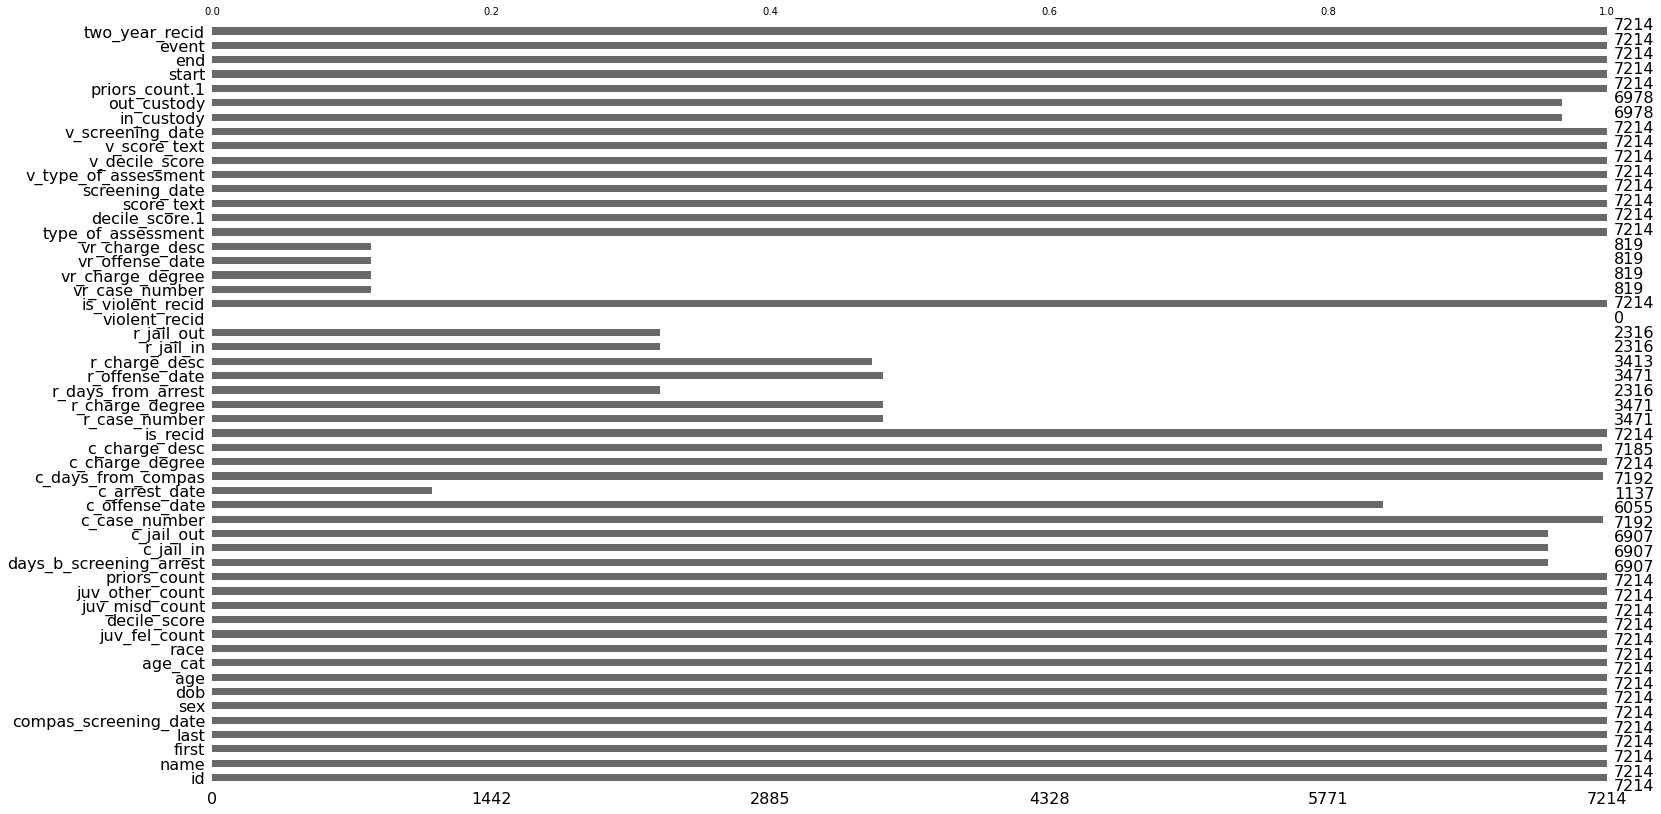

In [5]:
# Check which columns are missing data
msno.bar(df)

In [6]:
# List the columns are missing data
missing_data = pd.DataFrame(df.isna().sum()).sort_values(by = 0, ascending=False)
missing_data.columns = ["count"]
missing_data[missing_data["count"]!=0]

,count
violent_recid,7214
vr_charge_degree,6395
vr_case_number,6395
vr_offense_date,6395
vr_charge_desc,6395
c_arrest_date,6077
r_jail_out,4898
r_jail_in,4898
r_days_from_arrest,4898
r_charge_desc,3801


In [7]:
label = df["two_year_recid"]

In [8]:
# Convert strings to datetime
df["out_custody"] = pd.to_datetime(df["out_custody"], format="%Y-%m-%d")
df["in_custody"] = pd.to_datetime(df["in_custody"], format="%Y-%m-%d")

In [9]:
# Create a column which has boolean values - if in_custody has is NA then the person is not in custody
df["not_in_custody"] = df["in_custody"].isna()
# Extract information for custody_duration
df["custody_duration"] = np.where(df["not_in_custody"], 0, abs((df["out_custody"] - df["in_custody"]).dt.days))
df["custody_duration"] = df["custody_duration"].astype(int)

In [10]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,not_in_custody,custody_duration
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,False,7
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,False,10
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,False,0
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaT,NaT,1,0,1174,0,0,True,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaT,NaT,2,0,1102,0,0,True,0


(0.0, 250.0)

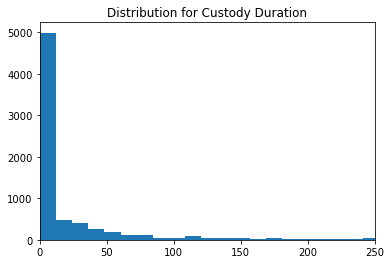

In [11]:
# Check the distibution for Custody Duration
plt.title("Distribution for Custody Duration")
plt.hist(df["custody_duration"],bins=500)
plt.xlim([0,250])

In [12]:
# Imput missing values for the vr_charge_degree column
# Because the values are missing in the original dataset we can fill it with 'Unknown'
df["vr_charge_degree"] = df["vr_charge_degree"].fillna('Unknown')

In [13]:
# Checking numbers after performing imputation
df["vr_charge_degree"].value_counts()

Unknown    6395
(M1)        344
(F3)        228
(F2)        162
(F1)         38
(M2)         19
(F7)         18
(MO3)         5
(F6)          4
(F5)          1
Name: vr_charge_degree, dtype: int64

In [14]:
un_priv_group = df.loc[:,'race']=='African-American'
priv_group = df.loc[:,'race']=='Caucasian'

In [15]:
# Select certain features of use
selected_cols_df = df[['age', 'sex', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'days_b_screening_arrest', 'is_recid', 'is_violent_recid']]

In [16]:
selected_cols_df.head()

,age,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,days_b_screening_arrest,is_recid,is_violent_recid
0,69,Male,0,0,0,0,F,-1.0,0,0
1,34,Male,0,0,0,0,F,-1.0,1,1
2,24,Male,0,0,1,4,F,-1.0,1,0
3,23,Male,0,1,0,1,F,NaN,0,0
4,43,Male,0,0,0,2,F,NaN,0,0


In [17]:
selected_cols_df = selected_cols_df.fillna(0)

In [18]:
# Check which columns are categorical and which are not
categorical = selected_cols_df.dtypes == object
ohe = OneHotEncoder(handle_unknown='ignore')
selected_cols_df_part1 = pd.DataFrame(ohe.fit_transform(selected_cols_df[selected_cols_df.columns[categorical]]).toarray())

In [19]:
# Scaling the numerical columns
scaler = StandardScaler()
selected_cols_df_part2 = pd.DataFrame(scaler.fit_transform(selected_cols_df[selected_cols_df.columns[~categorical]]))

In [20]:
# Concatenating the columns to form a DataFrame
selected_cols_transformed_df = pd.DataFrame(np.array(pd.concat([selected_cols_df_part1, selected_cols_df_part2], axis = 1)))

In [21]:
df = selected_cols_transformed_df.copy()

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,1.0,0.0,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,-0.056138,-0.962980,-0.357867
1,0.0,1.0,1.0,0.0,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,-0.056138,1.038443,2.794334
2,0.0,1.0,1.0,0.0,-0.909985,-0.141855,-0.187414,1.775750,0.108063,-0.056138,1.038443,-0.357867
3,0.0,1.0,1.0,0.0,-0.994103,-0.141855,1.873571,-0.218065,-0.506414,-0.042657,-0.962980,-0.357867
4,0.0,1.0,1.0,0.0,0.688252,-0.141855,-0.187414,-0.218065,-0.301588,-0.042657,-0.962980,-0.357867
...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0.0,1.0,1.0,0.0,-0.994103,-0.141855,-0.187414,-0.218065,-0.711240,-0.056138,-0.962980,-0.357867
7210,0.0,1.0,1.0,0.0,-0.994103,-0.141855,-0.187414,-0.218065,-0.711240,-0.056138,-0.962980,-0.357867
7211,0.0,1.0,1.0,0.0,1.865900,-0.141855,-0.187414,-0.218065,-0.711240,-0.056138,-0.962980,-0.357867
7212,1.0,0.0,0.0,1.0,-0.152925,-0.141855,-0.187414,-0.218065,-0.096763,-0.056138,-0.962980,-0.357867


In [23]:
# Helper functions 
def get_M(prototypes, x):
    return softmax(-cdist(x, prototypes), axis=1)

def get_xhat(prototypes, M):
    return np.matmul(M, prototypes)

def get_yhat(M, w):
    return np.clip(
        np.matmul(M, w.reshape((-1, 1))),
        np.finfo(float).eps,
        1.0 - np.finfo(float).eps
    )

# LFR Algorithm

The Objective of the algorithm is to convert the data into some representation and remove the attributes which provide the sensitive information and in this case we need to remove the effect of the "Race" attribute.
In the research paper: The main idea in our model is to map each individual, represented as a data point in a given input space, to a probability distribution in a new representation space. The aim of this new representation is to lose any information that can identify whether the person belongs to the protected subgroup, while retaining as much other
information as possible."
In this model we define prototypes which act as discriminative clusters. All the inputs are mapped to one of clusters in the prototypes which are then use to do the classification. Statistical parity induces an interesting constraint on the prototype assignments, forcing the associated probabilities to be the same in expectation for the protected and unprotected groups.


In [24]:
def LFR(params_init, x_unpriv, x_priv, y_unpriv, y_priv, k = 10, Ax=0.01, Ay=0.1, Az=0.5):
    
    num_unprivileged, n_features = x_unpriv.shape
    num_privileged = x_priv.shape[0]
    w = params_init[:k]
    prototypes = params_init[k:].reshape(k,-1)
    
    M_priv = get_M(prototypes, x_priv)
    x_hat_priv = get_xhat(prototypes, M_priv)
    y_hat_priv = get_yhat(M_priv, w)
    
    M_unpriv = get_M(prototypes, x_unpriv)
    x_hat_unpriv = get_xhat(prototypes, M_unpriv)
    y_hat_unpriv = get_yhat(M_unpriv, w)

    y = np.concatenate([y_unpriv.reshape((-1, 1)), y_priv.reshape((-1, 1))], axis=0)
    y_hat = np.concatenate([y_hat_unpriv, y_hat_priv], axis=0)
    
    Lx = np.mean((x_hat_unpriv - x_unpriv) ** 2) + np.mean((x_hat_priv - x_priv) ** 2)
    Ly = - np.mean(y * np.log(y_hat) + (1. - y) * np.log(1. - y_hat))
    Lz = np.mean(abs(np.mean(M_unpriv, axis=0) - np.mean(M_priv, axis=0)))

    total_loss = Ax*Lx + Ay*Ly + Az*Lz
    
    return total_loss

In [25]:
def plot_confusion_matrix(cm, label = 'African'):
    plt.figure()
    # cm = confusion_matrix(y_test, y_predict, labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix for ' + label)

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels([label, 'Not ' + label])
    ax.yaxis.set_ticklabels([label, 'Not ' + label])
        
    plt.show()

Combination Number 1 is being trained currently...


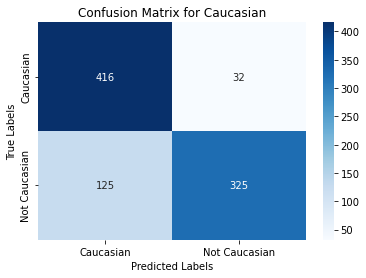

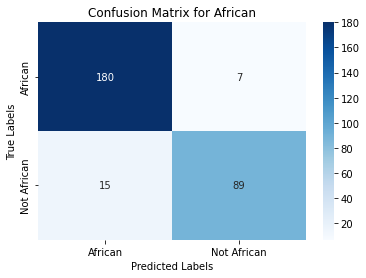

Results from Model-1 have been saved successfully!
Combination Number 2 is being trained currently...


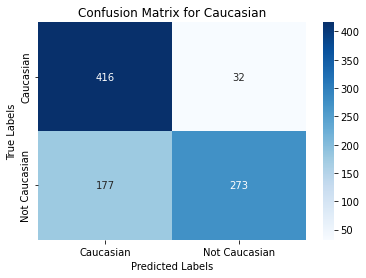

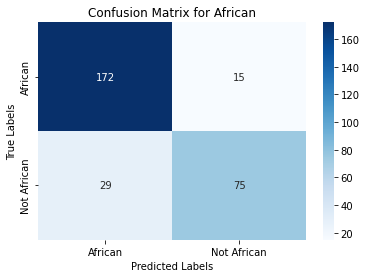

Results from Model-2 have been saved successfully!
Combination Number 3 is being trained currently...


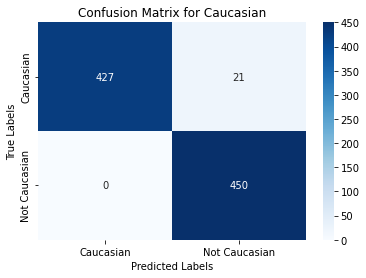

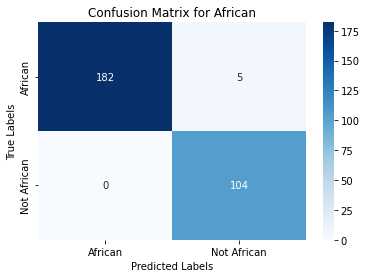

Results from Model-3 have been saved successfully!
Combination Number 4 is being trained currently...


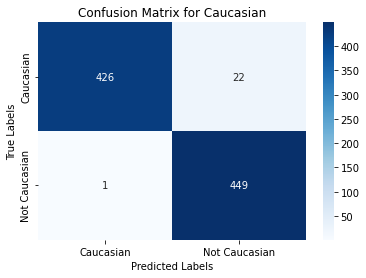

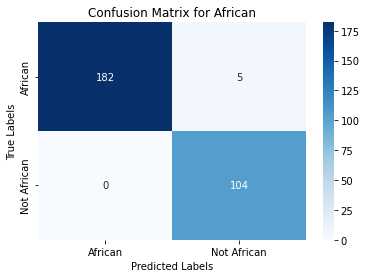

Results from Model-4 have been saved successfully!
Combination Number 5 is being trained currently...


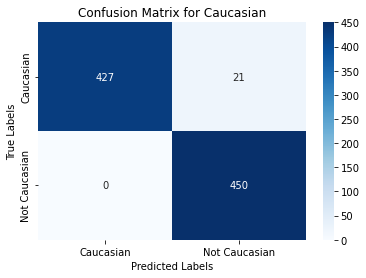

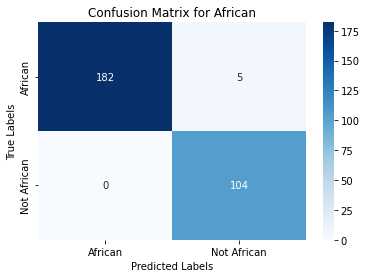

Results from Model-5 have been saved successfully!
Combination Number 6 is being trained currently...


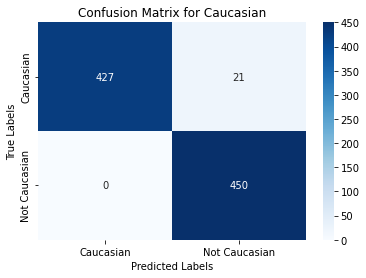

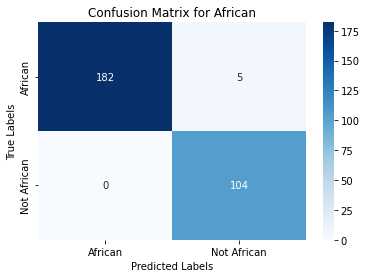

Results from Model-6 have been saved successfully!
Combination Number 7 is being trained currently...


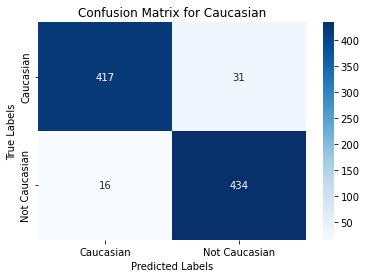

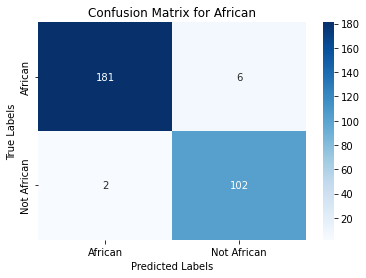

Results from Model-7 have been saved successfully!
Combination Number 8 is being trained currently...


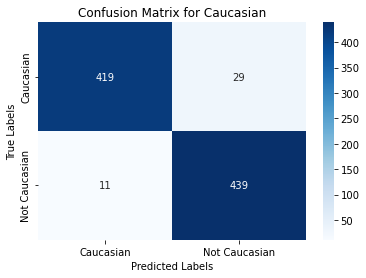

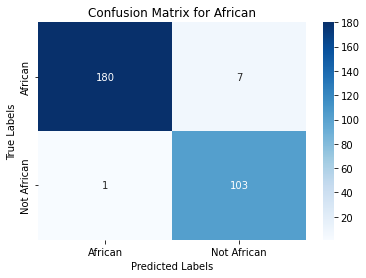

Results from Model-8 have been saved successfully!
Combination Number 9 is being trained currently...


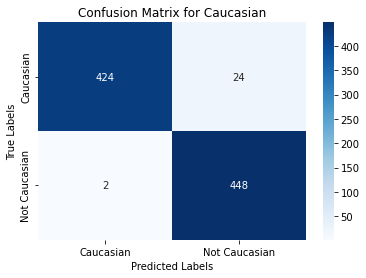

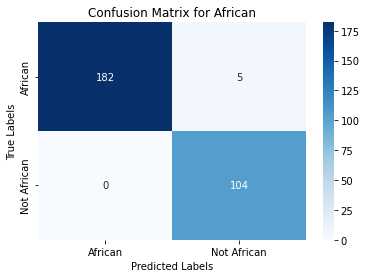

Results from Model-9 have been saved successfully!
Combination Number 10 is being trained currently...


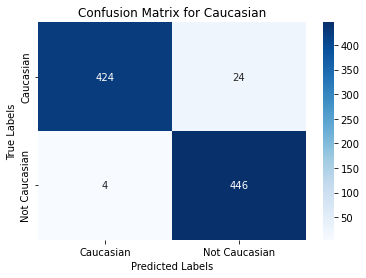

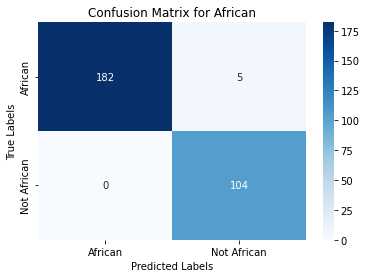

Results from Model-10 have been saved successfully!
Combination Number 11 is being trained currently...


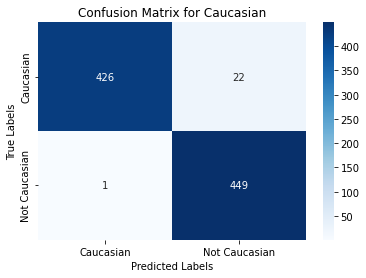

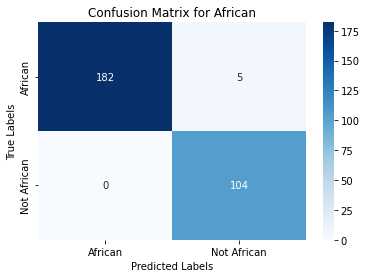

Results from Model-11 have been saved successfully!
Combination Number 12 is being trained currently...


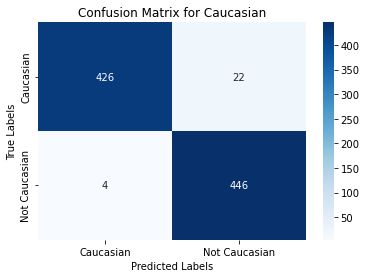

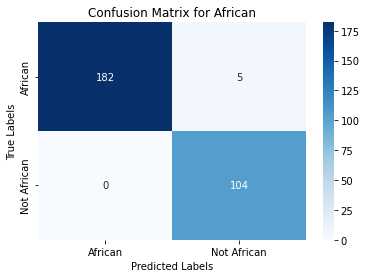

Results from Model-12 have been saved successfully!
Combination Number 13 is being trained currently...


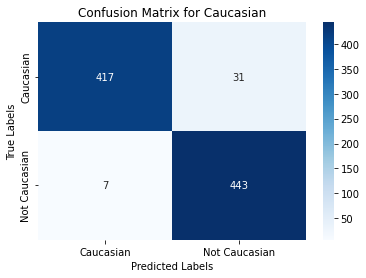

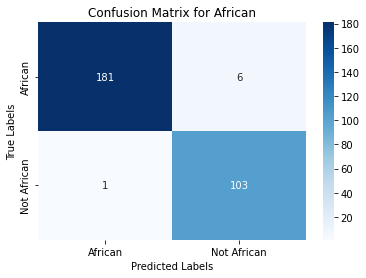

Results from Model-13 have been saved successfully!
Combination Number 14 is being trained currently...


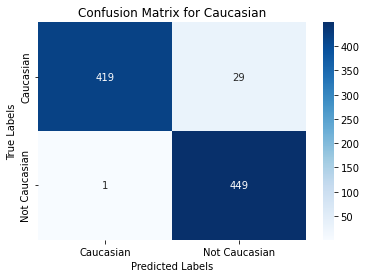

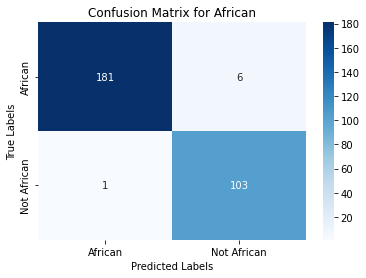

Results from Model-14 have been saved successfully!
Combination Number 15 is being trained currently...


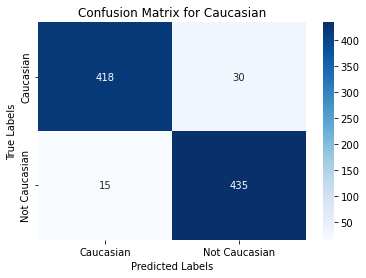

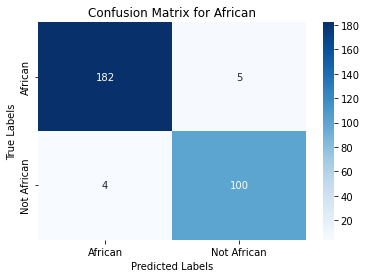

Results from Model-15 have been saved successfully!
Combination Number 16 is being trained currently...


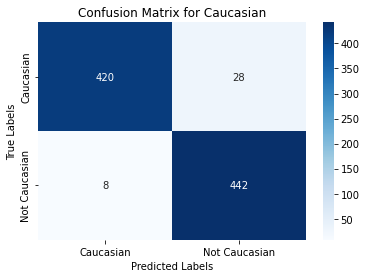

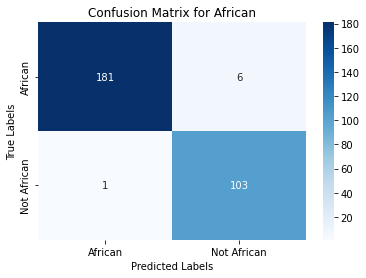

Results from Model-16 have been saved successfully!
Combination Number 17 is being trained currently...


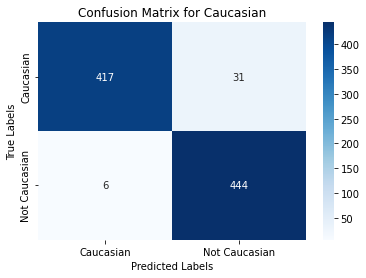

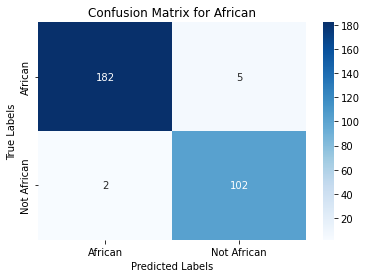

Results from Model-17 have been saved successfully!
Combination Number 18 is being trained currently...


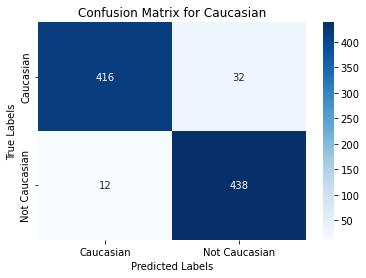

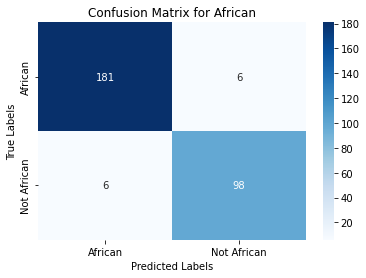

Results from Model-18 have been saved successfully!


In [33]:
maxiter=15000
maxfun=5000
k = 10

Ax_list = [0.01, 0.1, 1]
Ay_list = [0.01, 0.1, 1]
Az_list = [0.5, 1]
X_train_bfr_tform, X_test_bfr_tform, y_train_bfr_tform, y_test_bfr_tform = train_test_split(df, label, stratify = label,
                                                                                            test_size=0.2, random_state=42)
final_result = []
test_caucasian = X_test_bfr_tform.iloc[:,2] == 1
test_african = X_test_bfr_tform.iloc[:,0] == 1
caucasian_label = y_test_bfr_tform[test_caucasian]
african_label = y_test_bfr_tform[test_african]
output_dir = "../output"

t = 0
for Ax in Ax_list:
    for Ay in Ay_list:
        for Az in Az_list:
            print(f'Combination Number {t+1} is being trained currently...')
            itr_result = []
            num_train_samples, features_dim = np.shape(df)

            unpriv_sample_ids = df.iloc[:,0]==1
            priv_sample_ids = df.iloc[:,2]==1
            features_unpriv = np.array(df[unpriv_sample_ids])
            features_priv = np.array(df[priv_sample_ids])
            labels_unpriv = np.array(label[unpriv_sample_ids])
            labels_priv = np.array(label[priv_sample_ids])


            params_init = np.random.uniform(size=k + features_dim * k)
            bnd = [(0, 1)]*k + [(None, None)]*features_dim*k

            learned_model = optim.fmin_l_bfgs_b(LFR, x0=params_init, epsilon=1e-5,
                                                          args=(features_unpriv, features_priv,
                                                                labels_unpriv, labels_priv, k, Ax, Ay, Az),
                                                          bounds=bnd, approx_grad=True, maxfun=maxfun,
                                                          maxiter=maxiter)[0]
            w = learned_model[:k]
            prototypes = learned_model[k:].reshape((k, features_dim))

            threshold=0.5

            protected_attributes = np.array(df.iloc[:,:5]).reshape([-1, 1])
            unpriv_sample_ids = np.array(df.iloc[:,0]==1)
            priv_sample_ids = np.array(df.iloc[:,2]==1)
            features_unpriv = np.array(df[unpriv_sample_ids])
            features_priv = np.array(df[priv_sample_ids])
            labels_unpriv = np.array(label[unpriv_sample_ids])
            labels_priv = np.array(label[priv_sample_ids])
            
            M_priv = get_M(prototypes, features_priv)
            features_hat_priv = get_xhat(prototypes, M_priv)
            labels_hat_priv = get_yhat(M_priv, w)
            
            M_unpriv = get_M(prototypes, features_unpriv)
            features_hat_unpriv = get_xhat(prototypes, M_unpriv)
            labels_hat_unpriv = get_yhat(M_unpriv, w)

            transformed_features = np.zeros(shape=np.shape(df.iloc[:, 6:]))
            transformed_labels = np.zeros(shape=np.shape(label))
            transformed_features[unpriv_sample_ids] = features_hat_unpriv[:,6:]
            transformed_features[priv_sample_ids] = features_hat_priv[:,6:]
            transformed_labels[unpriv_sample_ids] = np.reshape(labels_hat_unpriv, [-1, ])
            transformed_labels[priv_sample_ids] = np.reshape(labels_hat_priv,[-1, ])
            transformed_bin_labels = (np.array(transformed_labels) > threshold).astype(np.float64)
            transformed_features = pd.DataFrame(transformed_features)
            X_train,X_test,y_train,y_test = train_test_split(transformed_features, label, stratify = label,
                                                             test_size=0.2, random_state=42)
            clf2 = LogisticRegression()
            
            start_time_fit = time.time()
            clf2.fit(X_train,y_train)
            end_time_fit = time.time()
            
            itr_result.append(clf2.score(X_test,y_test))
            
            start_time_predict = time.time()
            caucasian_confusion = confusion_matrix(caucasian_label, clf2.predict(np.array(X_test[test_caucasian])))
            african_confusion = confusion_matrix(african_label, clf2.predict(np.array(X_test[test_african])))
            end_time_predict = time.time()
            
            plot_confusion_matrix(caucasian_confusion, label = 'Caucasian')
            plot_confusion_matrix(african_confusion, label = 'African')
            itr_result.append(caucasian_confusion[1,0]/(caucasian_confusion[0,0]+caucasian_confusion[1,0]))
            itr_result.append(caucasian_confusion[0,1]/(caucasian_confusion[1,1]+caucasian_confusion[0,1]))
            itr_result.append((caucasian_confusion[0,0]+caucasian_confusion[1,1])/(np.sum(caucasian_confusion)))
            itr_result.append(african_confusion[1,0]/(african_confusion[0,0]+african_confusion[1,0]))
            itr_result.append(african_confusion[0,1]/(african_confusion[1,1]+african_confusion[0,1]))
            itr_result.append((african_confusion[0,0]+african_confusion[1,1])/(np.sum(african_confusion)))
            itr_result.append(Ax)
            itr_result.append(Ay)
            itr_result.append(Az)
            itr_result.append(end_time_fit - start_time_fit)
            itr_result.append(end_time_predict - start_time_predict)

            output_file_path = os.path.join(output_dir, f"transformed{t+1}.csv")
            transformed_features.to_csv(output_file_path, index = False)
            t += 1
            final_result.append(itr_result)
            print(f'Results from Model-{t} have been saved successfully!')

In [34]:
result = pd.DataFrame(final_result)
result.columns = ["accuracy","caucasian FN rate","caucasian FP rate", "caucasian accuracy","african FN rate", "african FP rate", "african accuracy", "Ax_value", "Ay_value", "Az_value", "fit time", "predict time"]

In [35]:
result.sort_values('accuracy', ascending = False)

,accuracy,caucasian FN rate,caucasian FP rate,caucasian accuracy,african FN rate,african FP rate,african accuracy,Ax_value,Ay_value,Az_value,fit time,predict time
2,0.866251,0.000000,0.044586,0.976615,0.000000,0.045872,0.982818,0.01,0.10,0.5,0.034776,0.002499
4,0.866251,0.000000,0.044586,0.976615,0.000000,0.045872,0.982818,0.01,1.00,0.5,0.029480,0.003214
5,0.866251,0.000000,0.044586,0.976615,0.000000,0.045872,0.982818,0.01,1.00,1.0,0.037102,0.002328
3,0.864865,0.002342,0.046709,0.974388,0.000000,0.045872,0.982818,0.01,0.10,1.0,0.025738,0.003470
10,0.864865,0.002342,0.046709,0.974388,0.000000,0.045872,0.982818,0.10,1.00,0.5,0.029143,0.004556
8,0.862786,0.004695,0.050847,0.971047,0.000000,0.045872,0.982818,0.10,0.10,0.5,0.016212,0.002194
11,0.862786,0.009302,0.047009,0.971047,0.000000,0.045872,0.982818,0.10,1.00,1.0,0.016851,0.002187
9,0.861400,0.009346,0.051064,0.968820,0.000000,0.045872,0.982818,0.10,0.10,1.0,0.021304,0.002076
13,0.859321,0.002381,0.060669,0.966592,0.005495,0.055046,0.975945,1.00,0.01,1.0,0.012257,0.001855
15,0.855163,0.018692,0.059574,0.959911,0.005495,0.055046,0.975945,1.00,0.10,1.0,0.013778,0.002090
